# Laboratorio 4

#### Sebastian Aristondo 20880
#### Daniel Gonzalez 20293

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Limpieza y preprocesamiento

El dataset tiene los datos crudos, por lo que debemos de limpiarlos y preprocesarlos para poder trabajar con ellos. Para esto, se utilizo la libreria pandas para poder leer el archivo csv y poder trabajar con el. Luego utilizaremos varias funciones de nltk para poder limpiar los datos y dejarlos listos para poder trabajar con ellos.

In [55]:
data = pd.read_csv('train.csv')

In [56]:
def remove_urls(text):
    url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return re.sub(url_pattern, '', text)

In [57]:
data['text'] = data['text'].apply(remove_urls)

In [58]:
data['text'] = data['text'].str.replace('[^a-zA-Z]', ' ', regex=True)
data['text'] = data['text'].apply(lambda x: x.lower())

Se realizaron tres acciones iniciales para limpiar y preprocesar datos. Primero se eliminó cualquier URL de los datos usando una expresión regular. También se mantuvieron solamente los caracteres que estuvieran de la a a la z, mayúsculas o minúsculas. Esto quiere decir que se quitó cualquier caracter como "#" o "@" y signos de puntuación. Por otra parte, se pasaron todas las palabras a minúsculas.

In [59]:
def remove_stop_words(sentence):
    stop_words = set(stopwords.words('spanish'))  # Cambia 'spanish' por el idioma que necesites
    words = sentence.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    new_sentence = ' '.join(filtered_words)
    return new_sentence

data['text_clean'] = data['text'].apply(remove_stop_words)


Para que nuestro modelo tenga un mejor desempeño, quitaremos las palabras que no aportan información al modelo. Estas palabras se conocen como "stopwords". Para esto, usaremos la librería nltk. Esta librería tiene una lista de stopwords en inglés que usaremos para quitar las palabras que no aportan información.

In [60]:
def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return lemmatized_words

data['text_lemmatized'] = data['text_clean'].apply(lambda x: lemmatize_words(x.split()))

El modelo no puede diferenciar entre correr, corriendo, correrá, etc. Para esto, usaremos un proceso llamado lemmatization. Este proceso consiste en convertir las palabras a su forma base. Por ejemplo, correr, corriendo, correrá, etc. se convertirán a correr. Esto nos ayudará a que el modelo pueda diferenciar entre palabras que tienen el mismo significado pero que están escritas de manera diferente.

## 2. Análisis exploratorio

In [61]:
data.head()

,id,keyword,location,text,target,text_clean,text_lemmatized
0,1,NaN,NaN,our deeds are the reason of this earthquake m...,1,our deeds are the reason of this earthquake ma...,"[our, deed, are, the, reason, of, this, earthq..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,forest fire near ronge sask canada,"[forest, fire, near, ronge, sask, canada]"
2,5,NaN,NaN,all residents asked to shelter in place are ...,1,all residents asked to shelter in place are be...,"[all, resident, asked, to, shelter, in, place,..."
3,6,NaN,NaN,people receive wildfires evacuation or...,1,people receive wildfires evacuation orders in ...,"[people, receive, wildfire, evacuation, order,..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala..."


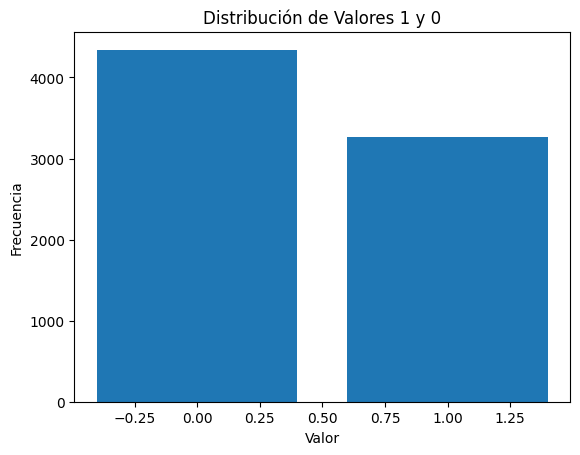

In [62]:
# Calcular la frecuencia de valores
value_counts = data['target'].value_counts()

# Crear el gráfico de barras
plt.bar(value_counts.index, value_counts.values)

# Etiquetas y título
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Distribución de Valores 1 y 0')

# Mostrar el gráfico
plt.show()